I did a simple experiment on Bayesian regression. Didn't want to reuse the code, to make sure I understand everything myself. I train the model and then verify the mean and standard variation of the posterior samples, which are both available to me analytically as well.

In [1]:
import torch
import torchsde
from tqdm import tqdm

In [2]:
import matplotlib.pyplot as plt

In [15]:
import numpy as np

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

The model is

\begin{align}
    \theta \sim \mathcal{N}(0, 1) \\
    x_i \sim \mathcal{N}(\theta, 1) \\
\end{align}

for $i = 1, \dots, N$. With the analytical posterior $p(\theta | x_1, \dots, x_N) = \mathcal{N}(\theta; \frac{\sum_{i=1}^N x_i}{N + 1}, \frac{1}{N + 1})$.

In [4]:
N = 100
true_theta = torch.randn([1], device=device)
true_xs = true_theta + torch.randn([N], device=device)

In [54]:
def log_prior(theta):
    return -0.5 * theta**2

def log_likelihood(xs, theta):
    return -0.5 * torch.sum((xs - theta)**2)

# Not the exact log_posterior, but a stochastic estimate of it, via a subsample of data
def log_posterior(theta, xs):
    # Currently this works for both batch_size = 5 and batch_size = 100 (see below)
    # But if the scaling is removed only works for batch_size = 100
    return log_prior(theta) + (N / xs.shape[0]) * log_likelihood(xs, theta)

In [32]:
def loss(sde, xs, dt=0.05):
    n_steps = int(1.0 / dt)
    
    # Currently not doing any batching for theta, keeping things simple
    theta_0 = torch.tensor([[0.0]], device=device)
    
    ts = torch.linspace(0, 1, n_steps, device=device)
    
    thetas = torchsde.sdeint(sde, theta_0, ts, method="euler", dt=dt)
    theta_1 = thetas[-1]
    
    fs = torch.vmap(sde.f)(ts, thetas)
    
    gamma = sde.gamma
    
    energy_cost = torch.sum(fs**2) * dt / (2 * gamma)
    
    terminal_cost = - theta_1**2 / (2 * gamma) - log_posterior(theta_1, xs)
    
    return energy_cost + terminal_cost

In [33]:
class SDE(torch.nn.Module):
    
    def __init__(self, gamma):
        super().__init__()
        
        self.nn = torch.nn.Sequential(
            torch.nn.Linear(2, 10),
            torch.nn.ReLU(),
            torch.nn.Linear(10, 10),
            torch.nn.ReLU(),
            torch.nn.Linear(10, 10),
            torch.nn.ReLU(),
            torch.nn.Linear(10, 1)
        )
        
        self.noise_type = "diagonal"
        self.sde_type = "ito"
        
        self.gamma = gamma
    
    def f(self, t, theta):
        t = t * torch.ones_like(theta)
        out =  self.nn(torch.cat((t, theta), dim=-1))
        return out
    
    def g(self, t, theta):
        out = torch.sqrt(self.gamma * torch.ones_like(theta))
        return out

In [45]:
gamma = 0.1**2
sde = SDE(gamma).to(device)

optimizer = torch.optim.Adam(sde.parameters(), lr=1e-3)

batch_size = 5

In [46]:
# Could probably use fewer iterations
for i in tqdm(range(10000)):
    optimizer.zero_grad()
    perm = torch.randperm(100)
    true_xs = true_xs[perm]
    l = loss(sde, true_xs[:batch_size], dt=0.05)
    l.backward()
    optimizer.step()

  0%|                                                                      | 0/10000 [00:00<?, ?it/s]/tmp/ipykernel_92105/1808098707.py:12: UserWarning: torch.vmap is an experimental prototype that is subject to change and/or deletion. Please use at your own risk. There may be unexpected performance cliffs due to certain operators not being implemented. To see detailed performance warnings please use `torch._C._debug_only_display_vmap_fallback_warnings(True) before the call to `vmap`.
  fs = torch.vmap(sde.f)(ts, thetas)
100%|██████████████████████████████████████████████████████████| 10000/10000 [04:10<00:00, 39.96it/s]


In [47]:
with torch.no_grad():
    thetas_0 = torch.zeros((10000, 1), device=device).float()
    
    dt = 0.01
    ts = torch.linspace(0, 1, 2, device=device)
    
    thetas_1 = torchsde.sdeint(sde, thetas_0, ts, method="euler", dt=0.01)[-1]

In [48]:
theta_samples = thetas_1.cpu().numpy()

(array([3.000e+00, 1.200e+01, 5.100e+01, 1.420e+02, 3.080e+02, 6.500e+02,
        1.029e+03, 1.399e+03, 1.620e+03, 1.609e+03, 1.325e+03, 8.660e+02,
        5.790e+02, 2.550e+02, 1.000e+02, 4.000e+01, 1.000e+01, 1.000e+00,
        0.000e+00, 1.000e+00]),
 array([-5.2383585, -5.1963367, -5.1543145, -5.112293 , -5.0702705,
        -5.028249 , -4.986227 , -4.944205 , -4.902183 , -4.860161 ,
        -4.818139 , -4.7761173, -4.734095 , -4.6920733, -4.650051 ,
        -4.6080294, -4.5660076, -4.5239854, -4.4819636, -4.4399414,
        -4.3979197], dtype=float32),
 <BarContainer object of 20 artists>)

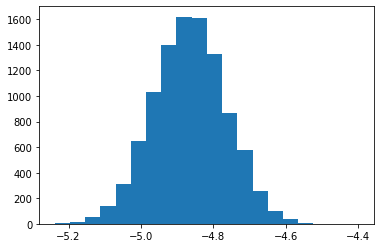

In [49]:
plt.hist(theta_samples, bins=20)

In [50]:
true_theta

tensor([-1.3388], device='cuda:0')

In [51]:
np.mean(theta_samples)

-4.8658133

In [52]:
np.std(theta_samples)

0.100294314

In [44]:
np.sqrt(1 / (N + 1))

0.09950371902099892